In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 18})

In [7]:
questions = pd.read_csv(os.path.join('EdNet-Contents', 'contents', 'questions.csv'))
lectures =  pd.read_csv(os.path.join('EdNet-Contents', 'contents', 'lectures.csv'))

kt3_files = os.listdir('KT3_csv_large')
kt3_paths = [os.path.join('KT3_csv_large', file) for file in kt3_files]

## Contents Exploration

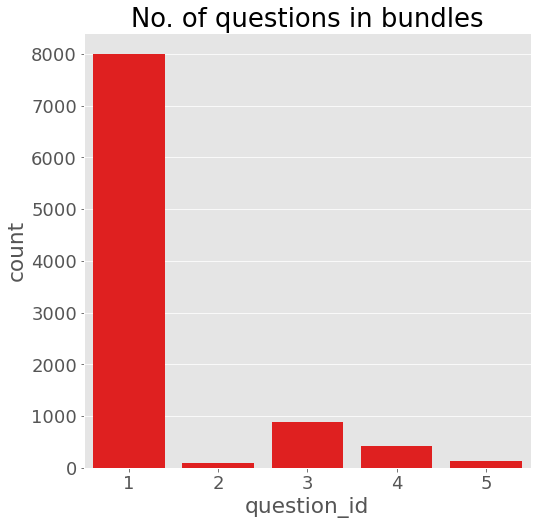

In [5]:
bundle_counts = questions.groupby('bundle_id').count()
fig, ax = plt.subplots(figsize = (8,8))
sns.countplot(data = bundle_counts, x = 'question_id', ax = ax, color = 'red')
plt.title('No. of questions in bundles')
plt.show()

### Question Distributions

In 'sprint', students choose a part that they want to study. After that, they can only solve questions belongs to the part that they choose, until they change to different part or select different source.

7 parts with each question belonging to only one part.


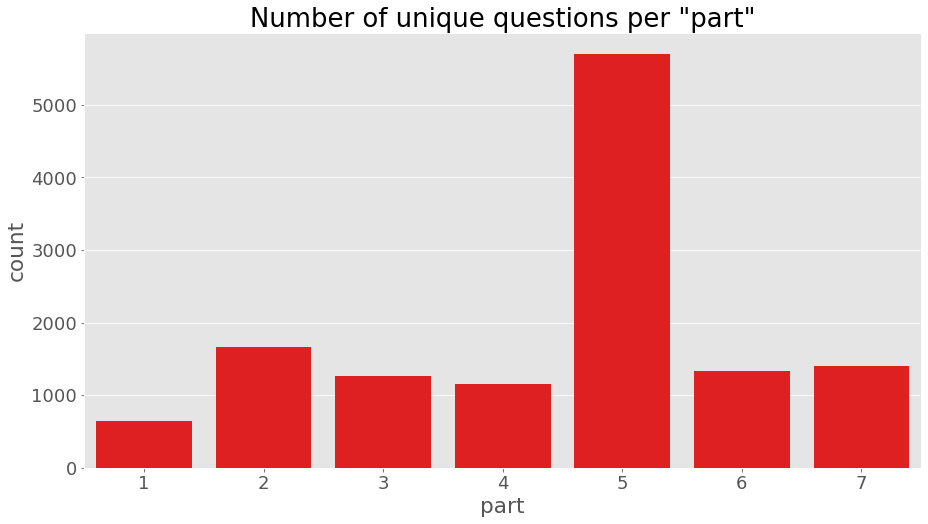

In [6]:
fig, ax = plt.subplots(figsize = (15,8))
print('7 parts with each question belonging to only one part.')

# Used this to check for unique assignment
#questions[['question_id', 'part']].groupby('question_id').nunique().value_counts()

sns.countplot(data = questions, x = 'part', color = 'red')
plt.title('Number of unique questions per "part"')
plt.savefig('Saved_Figs/unique_questions_per_part.pdf')
plt.show()

num_qs_per_part = questions.groupby('part').count()['question_id'].values

7 parts with each lecture belonging to only one part. Note that lectures with label -1 have no metadata


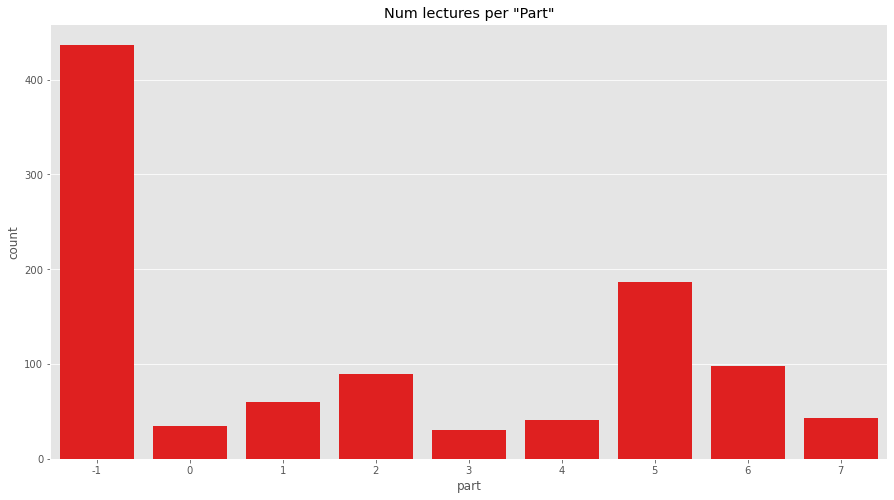

In [4]:
fig, ax = plt.subplots(figsize = (15,8))
print('7 parts with each lecture belonging to only one part. Note that lectures with label -1 have no metadata')

# Used this to check for unique assignment
#lectures[['lecture_id', 'part']].groupby('lecture_id').nunique().value_counts()

sns.countplot(data = lectures, x = 'part', color = 'red')
plt.title('Num lectures per "Part"')
plt.show()

# Excluding -1 part
num_ls_per_part = lectures.groupby('part').count()['lecture_id'].values

For a total of 189 tags. Note that the same question can exist in multiple tags


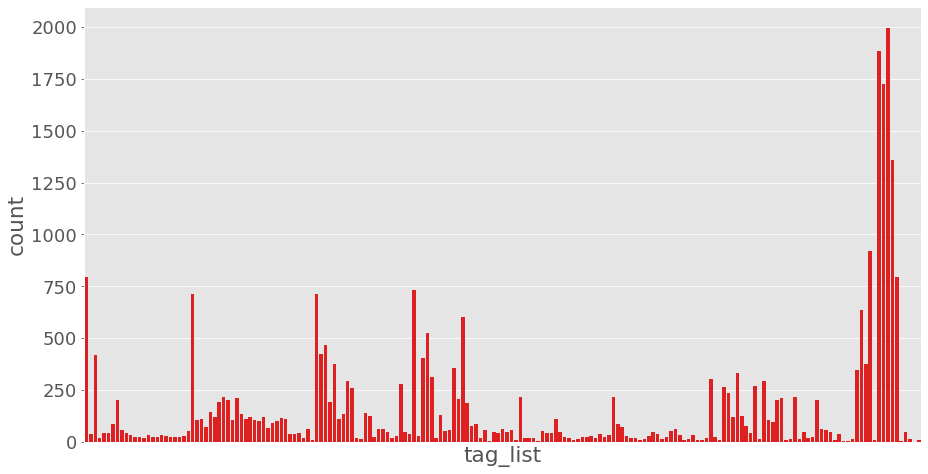

In [19]:
questions.loc[:,'tag_list'] = questions['tags'].str.split(';')
tag_counts = questions.explode('tag_list')
tag_counts['tag_list'] = tag_counts['tag_list'].astype('int')
tag_counts = tag_counts.sort_values('tag_list')

print('For a total of {} tags. Note that the same question can exist in multiple tags'.format(tag_counts['tag_list'].nunique()))
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(data = tag_counts, x = 'tag_list', color = 'red')
plt.xticks([])
#plt.title('Num. of unique questions in each skill')
plt.savefig('Saved_Figs/qn_skill_dist.pdf')
plt.show()

## Raw trajectory analyses

In [17]:
limit = 50000
kt3 = pd.read_csv(kt3_paths[0])
user_subset = kt3['username'].unique()[:limit]
kt3.query('username in @user_subset', inplace=True)

kt3 = kt3.merge(questions[['question_id', 'correct_answer', 'part']], left_on = 'item_id', right_on = 'question_id')
kt3.sort_values(['username','timestamp'], inplace = True)
kt3.reset_index(inplace = True, drop = True)

### Typical trajectory length per part
When a student enters a part, how many questions does he complete before switching parts

In [18]:
trajectory = (kt3['part'] != kt3['part'].shift(1)).cumsum()
kt_temp = kt3.copy()
kt_temp['trajectory'] = trajectory
kt_temp.groupby(['username', 'part', 'trajectory']).count()['timestamp'].value_counts()

del kt_temp

1       113204
2        48979
3        32754
4        23933
5        22254
         ...  
414          1
1592         1
569          1
668          1
1023         1
Name: timestamp, Length: 778, dtype: int64

### Distribution of question correctness (%)

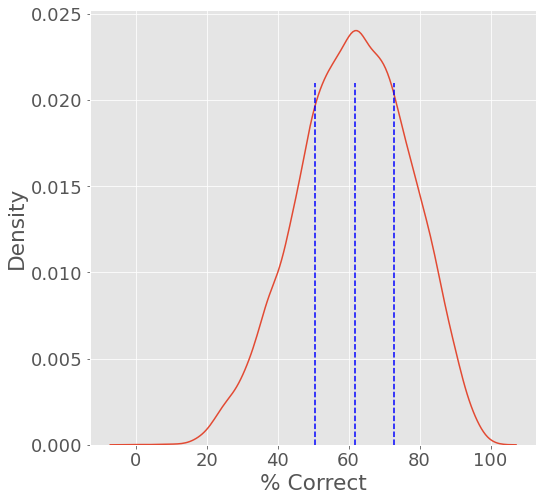

In [19]:
kt3['mark'] = (kt3['user_answer'] == kt3['correct_answer'])*1

question_correct = kt3.groupby('question_id').sum()['mark']
question_count = kt3.groupby('question_id').count()['mark']
question_diff = question_correct/question_count * 100

first_q = question_diff.quantile(0.25)
second_q = question_diff.quantile(0.5)
third_q = question_diff.quantile(0.75)

fig, ax = plt.subplots(figsize = (8,8))
sns.kdeplot(data = question_diff, ax = ax)
ax.plot([first_q,first_q], [0,0.021], '--b')
ax.plot([second_q,second_q], [0,0.021], '--b')
ax.plot([third_q,third_q], [0,0.021], '--b')
plt.xlabel('% Correct')
plt.savefig('Saved_Figs/question_diff_dist.pdf')
plt.show()

del kt3

**q_rank** quantizes questions according to observed percentage of wrong responses and its quantiles &rarr; 
* <q1 wrong responses: 1 (easy)
* <q2 wrong responses: 2 (medium)
* <q3 wrong responses: 3 (hard)
* \>q3 wrong responses: 3 (very hard)

## Deriving Some State Features

In [8]:
with open('init_state.txt', 'r') as file:
    init_state = file.read()
init_state = json.loads(init_state)
features = list(init_state.keys())

complete_traj = pd.read_csv('trajectories_KT3_200k.csv')
complete_traj['state'] = complete_traj['state'] .astype('str')
obs = complete_traj['state'].str.split('', expand = True).values[:,1:-1]

feat_to_incl = ["topic_fam", "correct_so_far","av_time"]

feat_idx = [features.index(feat) for feat in feat_to_incl]

complete_traj['state'] = obs[:, feat_idx].sum(axis = 1)

### Distribution of state observations

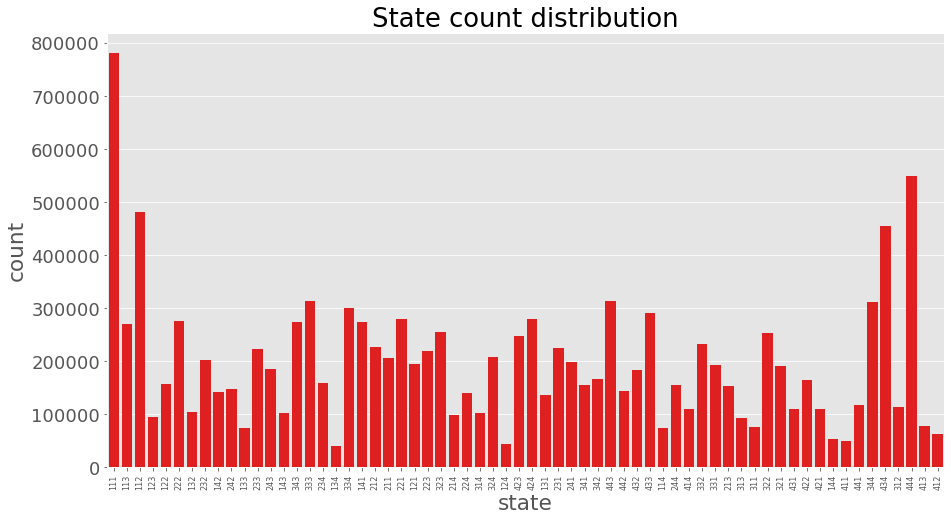

Minimum state support is :          username state    next_state  action  reward
0              u1   111  181013112118      24      -2
1              u1   113  181112112118      22       2
2              u1   112  181123112118      24       4
3              u1   123  181013113118      24      -2
4              u1   113  181013113118      24      -2
...           ...   ...           ...     ...     ...
12627957  u612984   111  181111012117      22       2
12627958  u612984   111  181011013117      24      -2
12627959  u612984   111  181011013117      24      -2
12627960  u612984   111  181011013117      24      -2
12627961  u612984   111  181011013117      23      -4

[12627962 rows x 5 columns]
Minimum state support is : 41111


In [11]:
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(data = complete_traj, x = 'state', color = 'red')
plt.xticks(rotation='vertical', fontsize = 8)
plt.title('State count distribution')
plt.savefig('Saved_Figs/state_count_dist.pdf')
plt.show()
print('Minimum state support is : {}'.format(complete_traj))
print('Minimum state support is : {}'.format(complete_traj.groupby('state').count()['username'].min()))

### Distribution of actions

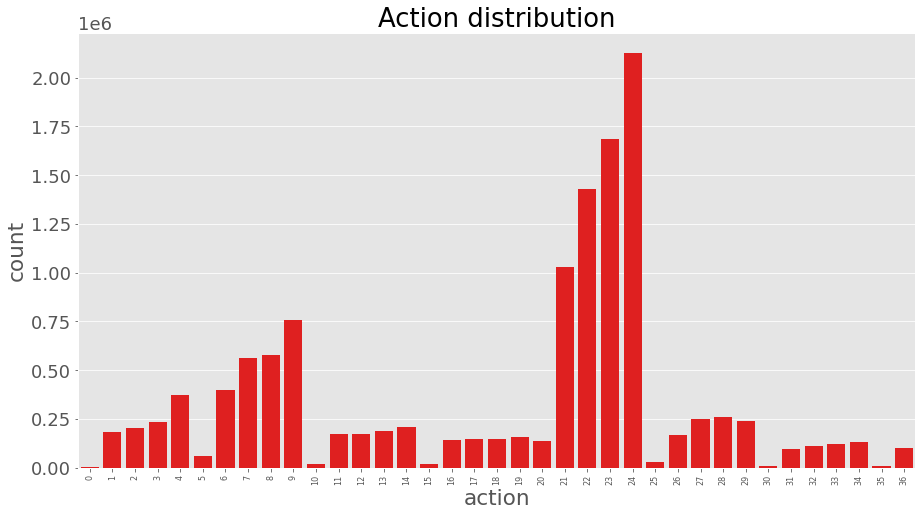

In [12]:
fig, ax = plt.subplots(figsize = (15,8))
sns.countplot(data = complete_traj, x = 'action', color = 'red')
plt.xticks(rotation='vertical', fontsize = 8)
plt.title('Action distribution')
plt.savefig('Saved_Figs/action_dist.pdf')
plt.show()